In [1]:
# VVD: Vertical Velocity Distribution
import vaex
import numpy as np
from glob import glob
from matplotlib import pyplot as plt
from os.path import join, abspath
from os import pardir
import sys
from scipy.stats import norm

In [2]:
root_dir = abspath(pardir)
root_dir

'/home2/s20321005/Thesis-Project'

In [3]:
if root_dir not in sys.path:
    sys.path.append(root_dir)
sys.path

['/home2/s20321005/Thesis-Project/4_Gravity',
 '/home2/s20321005/.conda/envs/vaex/lib/python38.zip',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8/lib-dynload',
 '',
 '/home2/s20321005/.local/lib/python3.8/site-packages',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8/site-packages',
 '/home2/s20321005/Thesis-Project']

In [4]:
from utils import phi_mod, n_gaussian

In [5]:
root_data_dir = abspath(join(pardir, "Data"))
root_data_dir

'/home2/s20321005/Thesis-Project/Data'

# MATH

for isothermal assumtion, therefore the DF for vertical velocity at some $z$ is fully contrained by the potensial $\Phi$

\begin{equation*}
    f_{wz}(w, z) = f_0(\sqrt{w^2 + 2\Phi(z)} 
\end{equation*}

Where $f_0$ is
\begin{aligned}
  f_{0}(|w|) \approx \sum_i^Na_i\mathcal{N}(|w|; \mu_i, \sigma_i)
\end{aligned}

Therefore, the DF for $w$ is
\begin{equation*}
    f_w(w) = A\int_{-\infty}^{\infty}f_0(\sqrt{w^2 + 2\Phi(z)})\text{d}z
\end{equation*}

Where $A$ is the normalization constant

In [6]:
name = "Baryon"
data_dir = join(root_data_dir, name)
df_baryon = vaex.open(join(data_dir, "baryon.hdf5"))
df_baryon

#,components,rho,e_rho,sigma_z,e_sigma_z
0,Molecular gas (H2),0.0104,0.00312,3.7,0.2
1,Cold atomic gas (HI(1)),0.0277,0.00554,7.1,0.5
2,Warm atomic gas (HI(2)),0.0073,0.0007,22.1,2.4
3,Hot ionized gas (HII),0.0005,3e-05,39.0,4.0
4,Giant stars,0.0006,6e-05,15.5,1.6
...,...,...,...,...,...
7,4 < MV < 5,0.0029,0.00029,18.0,1.8
8,5 < MV < 8,0.0072,0.00072,18.5,1.9
9,MV > 8,0.0216,0.0028,18.5,4.0
10,White dwarfs,0.0056,0.001,20.0,5.0


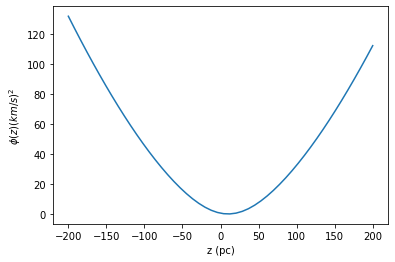

In [7]:
rhos = df_baryon["rho"].to_numpy()  # Msun/pc^3
sigmaz = df_baryon["sigma_z"].to_numpy() # km/s

# test the following dark values
rhoDM = 0.016 # Msun/pc^3
sigmaDD = 7 # Msun/pc^2
hDD = 20 # pc
R = 3.4E-3 # Msun/pc^3
nu0 = 1
zsun = -10

theta = dict(rhos=rhos, sigmaz=sigmaz, rhoDM=rhoDM, sigmaDD=sigmaDD, hDD=hDD, nu0=nu0, zsun=zsun, R=R)

zz = np.linspace(-200, 200, 50)
sigma_v = 5
phi = phi_mod(zz, **theta)

plt.plot(zz, phi)
plt.xlabel("z (pc)")
plt.ylabel(r"$\phi(z) (km/s)^2$")
plt.show()


In [8]:
name = "Velocity-Distribution"
velocity_dir = join(root_data_dir, name)

In [9]:
files = glob(join(velocity_dir, "gaia_*.hdf5"))
files_popt = glob(join(velocity_dir, "popt_gaia_*.hdf5"))
files.sort()
files_popt.sort()
files

['/home2/s20321005/Thesis-Project/Data/Velocity-Distribution/gaia_(-0.10)_(0.19).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution/gaia_(0.19)_(0.25).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution/gaia_(0.25)_(0.30).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution/gaia_(0.30)_(0.34).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution/gaia_(0.34)_(0.37).hdf5',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution/gaia_(0.37)_(0.40).hdf5']

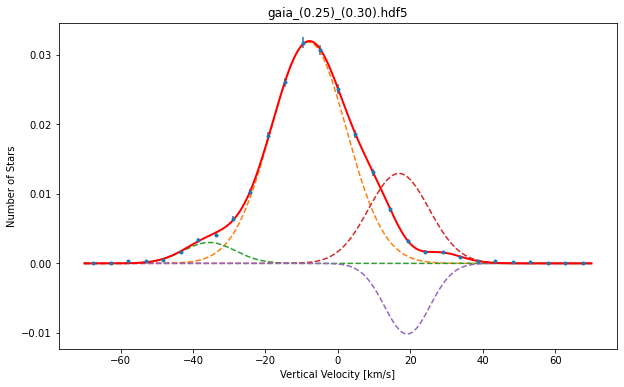

4

In [10]:
index = 2
file = files[index]
name = file.split("/")[-1]
df = vaex.open(file)

df_popt = vaex.open(files_popt[index])

w = df['w'].to_numpy()
wnum = df['wnum'].to_numpy()
werr = df['werr'].to_numpy()

popt = df_popt['popt'].to_numpy()

ws = np.linspace(-70, 70, 1000)
fw = n_gaussian(ws, *popt)

plt.figure(figsize=(10, 6))
plt.errorbar(w, wnum, yerr=werr, fmt='.')
for i in range(len(popt)//3):
    plt.plot(ws, popt[3*i]*norm.pdf(ws, popt[3*i+1], popt[3*i+2]), '--')
plt.plot(ws, fw, c="r", lw=2)
plt.xlabel("Vertical Velocity [km/s]")
plt.ylabel("Number of Stars")
plt.title(name)
plt.show()
dim = len(popt)//3
dim

In [92]:
from scipy.stats import norm

def n_gaussian_phi(w, phi, *popt):
    n = len(popt) // 3
    y = 0
    for i in range(n):
        a, mu, sigma = popt[3*i:3*i+3]
        ws = w - mu
        ws = np.sign(ws)*np.sqrt(ws**2+2*phi)
        y += a*norm.pdf(ws+mu, mu, sigma)
    return y

In [93]:
def fzw(z, w, **theta):
    sigma_w = theta['sigma_w']
    a = theta['a']
    w0 = theta['w0']
    popt = np.zeros(3*dim)
    for i in range(dim):
        popt[3*i] = a[i]
        popt[3*i+1] = w0[i]
        popt[3*i+2] = sigma_w[i]
    phis = phi_mod(z, **theta)
    return n_gaussian_phi(w, phis, *popt)

In [12]:
z = np.linspace(-1000, 1000, 200)
w = np.linspace(-70, 70, 200)

W, Z = np.meshgrid(w, z)

w0 = []
sigma_w = []
a_raw = []

for i in range(len(popt)//3):
    w0_i = popt[3*i+1]
    sigma_w_i = popt[3*i+2]
    a_raw_i = popt[3*i]
    
    w0.append(w0_i)
    sigma_w.append(sigma_w_i)
    a_raw.append(a_raw_i)

theta = dict(
    rhos=rhos, 
    sigmaz=sigmaz, 
    rhoDM=rhoDM, 
    sigmaDD=sigmaDD, 
    hDD=hDD, 
    nu0=nu0, 
    zsun=zsun, 
    R=R, 
    w0=w0, 
    sigma_w=sigma_w, 
    a=a_raw
)

FZW = fzw(Z, W, **theta)

plt.figure(figsize=(10, 6))
plt.contourf(W, Z, np.log(FZW), 100, cmap="jet")
plt.xlabel("Vertical Velocity [km/s]")
plt.ylabel("Height [pc]")
plt.axvline(w0[0], c="k", ls="--")
plt.axvline(0, c="k", ls="--")
plt.title(name)
plt.show()



NameError: name 'fzw' is not defined

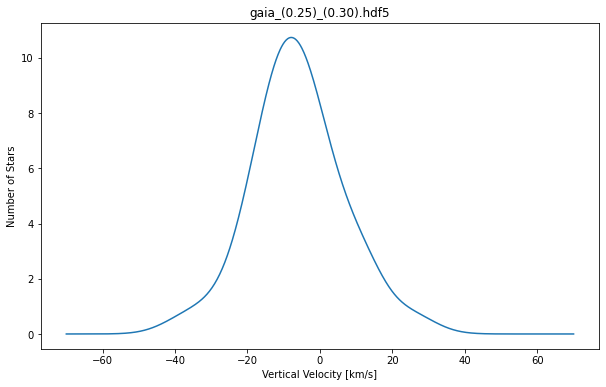

In [95]:
def fw_un(w, **theta):
    z = np.linspace(-1000, 1000, 1000)

    W, Z = np.meshgrid(w, z)
    FZW = fzw(Z, W, **theta)
    Fw = np.trapz(FZW, z, axis=0)
    return Fw

w = np.linspace(-70, 70, 1000)
Fw = fw_un(w, **theta)

plt.figure(figsize=(10, 6))
plt.plot(w, Fw)
plt.xlabel("Vertical Velocity [km/s]")
plt.ylabel("Number of Stars")
plt.title(name)
plt.show()

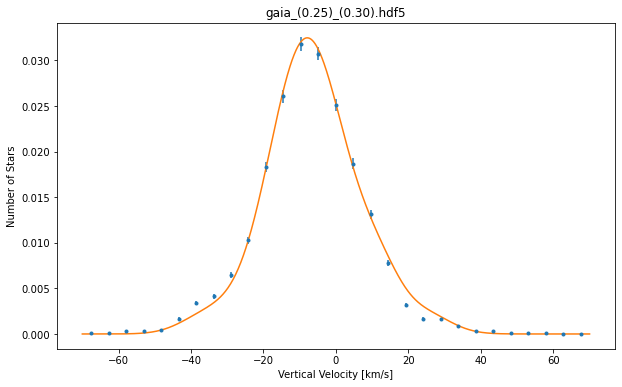

In [96]:
def fw(w, **theta):
    Fw = fw_un(w, **theta)
    Fw = Fw/np.trapz(Fw, w)
    return Fw

w = df['w'].to_numpy()
wnum = df['wnum'].to_numpy()
werr = df['werr'].to_numpy()

ws = np.linspace(-70, 70, 1000)
Fw = fw(ws, **theta)

plt.figure(figsize=(10, 6))
plt.errorbar(w, wnum, yerr=werr, fmt='.')
plt.plot(ws, Fw)
plt.xlabel("Vertical Velocity [km/s]")
plt.ylabel("Number of Stars")
plt.title(name)
plt.show()

# load from utils

In [11]:
from utils import fw

In [36]:
import numpy as np
from scipy.stats import norm
from utils import phi_mod

def n_gaussian_phi(w, phi, *popt):
    n = len(popt) // 3
    y = 0
    for i in range(n):
        a, mu, sigma = popt[3*i:3*i+3]
        ws = w - mu
        ws = np.sign(ws)*np.sqrt(ws**2+2*phi)
        y += a*norm.pdf(ws+mu, mu, sigma)
    return y

def fzw(z, w, **theta):
    sigma_w = theta['sigma_w']
    a = theta['a']
    w0 = theta['w0']
    dim = len(a)
    popt = np.zeros(3*dim)
    for i in range(dim):
        popt[3*i] = a[i]
        popt[3*i+1] = w0[i]
        popt[3*i+2] = sigma_w[i]
    phis = phi_mod(z, **theta)
    return n_gaussian_phi(w, phis, *popt)

def fw_un(w, **theta):
    z = np.linspace(-1000, 1000, 1000)

    W, Z = np.meshgrid(w, z)
    FZW = fzw(Z, W, **theta)
    Fw = np.trapz(FZW, z, axis=0)
    return Fw

def fw(w, **theta):
    Fw = fw_un(w, **theta)
    Fw = Fw/np.trapz(Fw, w)
    return Fw

fzw(1, 1, **theta)

0.02367038043068901

In [12]:
w0 = []
sigma_w = []
a_raw = []

for i in range(len(popt)//3):
    w0_i = popt[3*i+1]
    sigma_w_i = popt[3*i+2]
    a_raw_i = popt[3*i]
    
    w0.append(w0_i)
    sigma_w.append(sigma_w_i)
    a_raw.append(a_raw_i)

theta = dict(
    rhos=rhos, 
    sigmaz=sigmaz, 
    rhoDM=rhoDM, 
    sigmaDD=sigmaDD, 
    hDD=hDD, 
    nu0=nu0, 
    zsun=zsun, 
    R=R, 
    w0=w0, 
    sigma_w=sigma_w, 
    a=a_raw
)

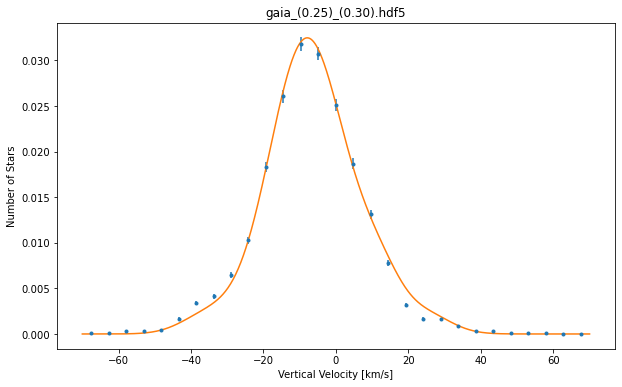

In [13]:
w = df['w'].to_numpy()
wnum = df['wnum'].to_numpy()
werr = df['werr'].to_numpy()

ws = np.linspace(-70, 70, 1000)
Fw = fw(ws, **theta)

plt.figure(figsize=(10, 6))
plt.errorbar(w, wnum, yerr=werr, fmt='.')
plt.plot(ws, Fw)
plt.xlabel("Vertical Velocity [km/s]")
plt.ylabel("Number of Stars")
plt.title(name)
plt.show()